## Imports <a class="anchor" id="first-bullet"></a>

In [1]:
#!pip install music21

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import music21 as m21

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from catboost import CatBoostClassifier

from IPython.display import Image
Image("img/picture.png")
import warnings
warnings.filterwarnings("ignore")

# Project overview <a class="anchor" id="second-bullet"></a>

The project aims to develop a model capable to humanise a specific form of music notation, i. e. tablature (tab). Most of western music is written in staff notation, but for some specific instruments like guitar or bass in popular music, tablatures are also very common, especially for people with little to no music theory knowledge, as it allows to read music through the position on the instrument and not the notes themselves.

Modern music notation softwares are capable to convert music sheets from staff to tab notation, but the conversion doesn't take into account the practicality of the positions on the instruments, leading to music parts that are technically impossible to play. The musician who wants to convert a staff notated music sheet into tablature must therefore edit the position of each note by hand, and it's a long and tedious work.

The aim of this project is to train a ML model on humanly playable tablatures, in order to be able to make a conversion from staff notation to tab that it's actually playable by a human.

<img src="images/three steps.jpg" width=500/>

Two main formats are used nowadays to deal with music notation digitally: <b>MIDI</b> and <b>MusicXML</b>, but only the latter is capable of storing the information of the string and fret (i. e. the position on the instrument) of the note played. Here's an example taken from the bass part of the jazz standard "Sweet Home Chicago".

In [3]:
fn = "musicxml/Sweet.musicxml"

with open(fn, 'r') as stream:
    xml_str = stream.read()

start = xml_str.find('<note')
end = xml_str[start:].find('</note>') + start + len('</note>')
print(xml_str[start:end])

<note>
				<rest/>
				<duration>16</duration>
				<voice>1</voice>
				<type>whole</type>
				<staff>1</staff>
			</note>


The first note of the music sheet is a note of duration 16 thirty-second notes, which is equal to a half note. 

# Functions

These are the functions used for the project.

In [4]:
def xml_to_list(xml):
    """Convert a music xml file to a list of note events

    Notebook: C1/C1S2_MusicXML.ipynb

    Args:
        xml (str or music21.stream.Score): Either a path to a music xml file or a music21.stream.Score

    Returns:
        score (list): A list of note events where each note is specified as
            ``[start, duration, pitch, velocity, label]``
    """

    if isinstance(xml, str):
        xml_data = m21.converter.parse(xml)
    elif isinstance(xml, m21.stream.Score):
        xml_data = xml
    else:
        raise RuntimeError('midi must be a path to a midi file or music21.stream.Score')

    score = []

    for part in xml_data.parts:
        for note in part.flat.notes:
            measure = note.measureNumber
            pitch = note.pitch.ps
            string = str(note.articulations[0])[-2:-1]
            fret = str(note.articulations[1])[-3:-1]
            score.append([pitch, string, fret])
    return score

In [5]:
def add_tablature(fn, df_raw):
    "Adds a tablature to the DataFrame"
    xml_data = m21.converter.parse(fn)
    xml_list = xml_to_list(xml_data)

    df_temp = pd.DataFrame(xml_list, columns=['pitch', 'string', 'fret'])
    df_temp.drop(columns=['pitch'], inplace=True)
    return pd.concat([df_raw, df_temp], ignore_index=True)

In [6]:
def generate_contextual_dataframe(df):
    "Adds contextual information to the DataFrame, similarly to the CBoW technique in NLP"
    
    data = list()
    
    for i in range(len(df)):
        try:
            data.append([df.iloc[i-2, 0], df.iloc[i-2, 1], df.iloc[i-1, 0], df.iloc[i-1, 1], df.iloc[i, 0], df.iloc[i, 1], df.iloc[i+1, 0], df.iloc[i+1, 1], df.iloc[i+2, 0], df.iloc[i+2, 1]])
        except:
            data.append([df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 0], df.iloc[i, 1], df.iloc[i, 0], df.iloc[i, 1]])
            
    df = pd.DataFrame(data = data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2'])
    df['y'] = df.s0
    
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(int)
    return df

In [7]:
# functions for data augmentation

def augment_data_up(row):
    if row[5] + 5 <= 15 and row[4] < 4 :
        row[4] += 1
        row[5] += 5
    return row

def augment_data_all_up(row):
    for i in range(1,11,2):
        if row[i] + 5 <= 15 and row[i-1] < 4 :
            row[i-1] += 1
            row[i] += 5
    return row

def augment_data_down(row):
    if row[5] - 5 >= 0 and row[4] > 1:
        row[4] -= 1
        row[5] -= 5
    return row

def augment_data_all_down(row):
    for i in range(1,11,2):
        if row[i] - 5 >= 0 and row[i-1] > 1:
            row[i-1] -= 1
            row[i] -= 5
    return row

In [8]:
def lower_octave(df):
    "Lowers each note of the DataFrame by one octave"
    df['pitch'] -= 12.0
    df['string'] += 2.0
    df['fret'] -= 2.0
    mask = df['fret'] < 0
    df.loc[mask, ['string', 'fret']] += [1.0, 5.0]
            
    return df

In [9]:
def rescale_tab(row):
    "Rescales a computer-generated tablature to adjust the data to the training data used for the model"
    for i in range(1,11,2):
        if row[i] > 12 and row[i-1] > 1:        
            while row[i] > 12:
                row[i-1] -= 1
                row[i] -= 5
    return row

In [10]:
def regenerate_fret(row):
    "Regenerates the fret position from the newly-predicted string and the original string-fret combination"
    if row[0] == row[2] : return row[1]
    if row[0] > row[2] : return row[1] - (row[0] - row[2]) * 5
    if row[0] < row[2] : return row[1] + (row[2] - row[0]) * 5

# Loading data

We load the data of the same music score and we extract only the tags string and fret.

In [11]:
fn = "musicxml/Sweet.musicxml"

xml_data = m21.converter.parse(fn)
xml_list = xml_to_list(xml_data)

df_raw = pd.DataFrame(xml_list, columns=['pitch', 'string', 'fret'])
df_raw.drop(columns=['pitch'], inplace=True)
df_raw

,string,fret
0,3,8
1,4,6
2,4,7
3,4,8
4,4,8
...,...,...
417,3,5
418,3,3
419,4,5
420,4,1


Now we add to the DataFrame all the other tablatures to be used to train the model.

In [12]:
df_raw = add_tablature("musicxml/Alexander.musicxml", df_raw)
df_raw = add_tablature("musicxml/Amazing.musicxml", df_raw)
df_raw = add_tablature("musicxml/At last.musicxml", df_raw)
df_raw = add_tablature("musicxml/Basie.musicxml", df_raw)
df_raw = add_tablature("musicxml/Besame.musicxml", df_raw)
df_raw = add_tablature("musicxml/Blue.musicxml", df_raw)
df_raw = add_tablature("musicxml/Cantaloupe.musicxml", df_raw)
df_raw = add_tablature("musicxml/Copains.musicxml", df_raw)
df_raw = add_tablature("musicxml/Creep.musicxml", df_raw)
df_raw = add_tablature("musicxml/Easy.musicxml", df_raw)
df_raw = add_tablature("musicxml/Everybody.musicxml", df_raw)
df_raw = add_tablature("musicxml/Feeling.musicxml", df_raw)
df_raw = add_tablature("musicxml/Final.musicxml", df_raw)
df_raw = add_tablature("musicxml/Gonna.musicxml", df_raw)
df_raw = add_tablature("musicxml/Hallelujah.musicxml", df_raw)
df_raw = add_tablature("musicxml/If.musicxml", df_raw)
df_raw = add_tablature("musicxml/It dont.musicxml", df_raw)
df_raw = add_tablature("musicxml/Its oh.musicxml", df_raw)
df_raw = add_tablature("musicxml/Ipanema.musicxml", df_raw)
df_raw = add_tablature("musicxml/Jingle.musicxml", df_raw)
df_raw = add_tablature("musicxml/Louis.musicxml", df_raw)
df_raw = add_tablature("musicxml/Mack.musicxml", df_raw)
df_raw = add_tablature("musicxml/Mancini.musicxml", df_raw)
df_raw = add_tablature("musicxml/Manha.musicxml", df_raw)
df_raw = add_tablature("musicxml/One.musicxml", df_raw)
df_raw = add_tablature("musicxml/Over.musicxml", df_raw)
df_raw = add_tablature("musicxml/Proud.musicxml", df_raw)
df_raw = add_tablature("musicxml/Respect.musicxml", df_raw)
df_raw = add_tablature("musicxml/Seven.musicxml", df_raw)
df_raw = add_tablature("musicxml/Should.musicxml", df_raw)
df_raw = add_tablature("musicxml/Smoke.musicxml", df_raw)
df_raw = add_tablature("musicxml/Son.musicxml", df_raw)
df_raw = add_tablature("musicxml/Summertime.musicxml", df_raw)
df_raw = add_tablature("musicxml/Take.musicxml", df_raw)
df_raw = add_tablature("musicxml/Tequila.musicxml", df_raw)
df_raw = add_tablature("musicxml/What.musicxml", df_raw)
df_raw = add_tablature("musicxml/When.musicxml", df_raw)
df_raw = add_tablature("musicxml/Wonderful.musicxml", df_raw)
df_raw = add_tablature("musicxml/Y.M.C.A.musicxml", df_raw)
df_raw = add_tablature("musicxml/Thriller.musicxml", df_raw)
df_raw = add_tablature("musicxml/White.musicxml", df_raw)
df_raw = add_tablature("musicxml/Cjam.musicxml", df_raw)

df_raw

,string,fret
0,3,8
1,4,6
2,4,7
3,4,8
4,4,8
...,...,...
14304,2,5
14305,2,7
14306,2,8
14307,4,6


# Generate dataset with contextual information

We want our model to be able to assess if each string-fret combination is humanly playable or not. In order to do so, we need some contextual information: if our string-fret combination is among others string-fret combinations that don’t allow the performer to play the note correctly, we need to change it. Therefore, we exploit the same technique used in the NLP model Continuous Bag of Words (CBoW) to gain contextual information from a sentence: we add to our target word – here our target string-fret combination – the two words – string-fret combinations – that precede and follow it.

Finally, we add our target value to predict, which is the column “string”.We know that, on a fretted instrumen, a note can be played on different string; so iIf we can correctly predict the string, and if the predicted string is different from the one in the input data, then we will simply add/subtract the distance in semitones that differentiates the input string to the output string. For bass guitar, this distance equals to 5 semitones, so we will add/subtract for multiples of 5, depending on our target string. Once the predicted string is calculated, we will retrieve the corresponding fret with a simple algorithm. By doing so, we will ensure that the note – or pitch – corresponding to the original string-fret combination is the same one of the predicted outputs.

In [13]:
df = generate_contextual_dataframe(df_raw)

df

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,4,6,4,6,3,8,4,6,4,7,3
1,4,6,3,8,4,6,4,7,4,8,4
2,3,8,4,6,4,7,4,8,4,8,4
3,4,6,4,7,4,8,4,8,4,1,4
4,4,7,4,8,4,8,4,1,3,5,4
...,...,...,...,...,...,...,...,...,...,...,...
14304,3,7,3,8,2,5,2,7,2,8,2
14305,3,8,2,5,2,7,2,8,4,6,2
14306,2,5,2,7,2,8,4,6,4,6,2
14307,4,6,4,6,4,6,4,6,4,6,4


This is how our dataset looks at this point of the data preparation phase. Our original columns “string” and “fret” are now named “s0” and “f0”, and before and after them we have added the preceding and following notes. The shape of our dataset is ready to be trained: from now on, we will refer to each of this numpy array as a string-fret pattern. However, it would be useful to extract more information from each pattern, in order to train the model on different string-fret combinations. We have therefore coded four different data augmentation algorithms:
The first one generates a new string-fret pattern where s0 and f0, i.e., the string-fret combination to be evaluated, is shifted up a string (if possible, we can’t go any further than s0 = 4 as the electric bass has only four strings):
>Ex. [ 3, 8, 3, 8, 3, 8, 4, 6, 4, 7, 3 ] becomes [ 3, 8, 3, 8, 4, 13, 4, 6, 4, 7, 3 ]

In [14]:
augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_up(list(df.loc[i])))

df_up = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_up

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,4,6,4,6,4,13,4,6,4,7,3
1,4,6,3,8,4,6,4,7,4,8,4
2,3,8,4,6,4,7,4,8,4,8,4
3,4,6,4,7,4,8,4,8,4,1,4
4,4,7,4,8,4,8,4,1,3,5,4
...,...,...,...,...,...,...,...,...,...,...,...
14304,3,7,3,8,3,10,2,7,2,8,2
14305,3,8,2,5,3,12,2,8,4,6,2
14306,2,5,2,7,3,13,4,6,4,6,2
14307,4,6,4,6,4,6,4,6,4,6,4


The second algorithm generates a new string-fret pattern where all the string-fret combinations are shifted up a string, with the same constraints of the previous one:
>Ex. [ 3, 8, 3, 8, 3, 8, 4, 6, 4, 7, 3 ] becomes [ 4, 13, 4, 13, 4, 13, 4, 6, 4, 7, 3 ]
>
>The last two string-fret combinations are not altered as it is not possible to go higher than the fourth string.

In [15]:
augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_all_up(list(df.loc[i])))

df_all_up = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_all_up

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,4,6,4,6,4,13,4,6,4,7,3
1,4,6,4,13,4,6,4,7,4,8,4
2,4,13,4,6,4,7,4,8,4,8,4
3,4,6,4,7,4,8,4,8,4,1,4
4,4,7,4,8,4,8,4,1,4,10,4
...,...,...,...,...,...,...,...,...,...,...,...
14304,4,12,4,13,3,10,3,12,3,13,2
14305,4,13,3,10,3,12,3,13,4,6,2
14306,3,10,3,12,3,13,4,6,4,6,2
14307,4,6,4,6,4,6,4,6,4,6,4


The third algorithm generates a new string-fret pattern where s0 and f0, i.e., the string-fret combination to be evaluated, is shifted down a string (if possible, we can’t go any lower than s0 = 1 as it is the first string of the instrument):
>Ex. [ 3, 8, 3, 8, 3, 8, 4, 6, 4, 7, 3 ] becomes [ 3, 8, 3, 8, 2, 3, 4, 6, 4, 7, 3 ]

In [16]:
augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_down(list(df.loc[i])))

df_down = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_down

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,4,6,4,6,2,3,4,6,4,7,3
1,4,6,3,8,3,1,4,7,4,8,4
2,3,8,4,6,3,2,4,8,4,8,4
3,4,6,4,7,3,3,4,8,4,1,4
4,4,7,4,8,3,3,4,1,3,5,4
...,...,...,...,...,...,...,...,...,...,...,...
14304,3,7,3,8,1,0,2,7,2,8,2
14305,3,8,2,5,1,2,2,8,4,6,2
14306,2,5,2,7,1,3,4,6,4,6,2
14307,4,6,4,6,3,1,4,6,4,6,4


The fourth algorithm generates a new string-fret pattern where all the string-fret combinations are shifted up a string, with the same constraints of the previous one:
>Ex. [ 3, 8, 3, 8, 3, 8, 4, 6, 4, 7, 3 ] becomes [ 2, 3, 2, 3, 2, 3, 3, 1, 3, 2, 3 ]

In [17]:
augmented_data = list()

for i in range(len(df)):
    augmented_data.append(augment_data_all_down(list(df.loc[i])))

df_all_down = pd.DataFrame(data = augmented_data, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
df_all_down

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,3,1,3,1,2,3,3,1,3,2,3
1,3,1,2,3,3,1,3,2,3,3,4
2,2,3,3,1,3,2,3,3,3,3,4
3,3,1,3,2,3,3,3,3,4,1,4
4,3,2,3,3,3,3,4,1,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...
14304,2,2,2,3,1,0,1,2,1,3,2
14305,2,3,1,0,1,2,1,3,3,1,2
14306,1,0,1,2,1,3,3,1,3,1,2
14307,3,1,3,1,3,1,3,1,3,1,4


We now merge all the augmented DataFrames and the original one together.

In [18]:
merged_data = list()
for i in range(len(df)):
   merged_data.append(list(df.iloc[i]))
   merged_data.append(list(df_up.iloc[i]))
   merged_data.append(list(df_all_up.iloc[i]))
   merged_data.append(list(df_down.iloc[i]))
   merged_data.append(list(df_all_down.iloc[i]))
merged_df = pd.DataFrame(data = merged_data, columns = ['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2', 'y'])
merged_df

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2,y
0,4,6,4,6,3,8,4,6,4,7,3
1,4,6,4,6,4,13,4,6,4,7,3
2,4,6,4,6,4,13,4,6,4,7,3
3,4,6,4,6,2,3,4,6,4,7,3
4,3,1,3,1,2,3,3,1,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...
71540,4,6,4,6,4,6,4,6,4,6,4
71541,4,6,4,6,4,6,4,6,4,6,4
71542,4,6,4,6,4,6,4,6,4,6,4
71543,4,6,4,6,3,1,4,6,4,6,4


It is important to note that each of these data transformation and augmentation techniques doesn’t change the note that is actually played: the string-fret combinations (3, 8) and (4, 13) correspond to the same exact note – an F in standard tuning. The only purpose of these algorithms is to generate more data for the algorithm to train on.
Let us provide another example. The array [ 3, 8, 3, 8, 4, 13, 4, 6, 4, 7, 3 ], generated from [ 3, 8, 3, 8, 3, 8, 4, 6, 4, 7, 3 ], will tell our model that, in that specific string-fret pattern, a F played on the 13th fret of the 4th string is the wrong string-fret combination, as the y-value 3 (the last of the pattern) indicates that the correct string to be predicted is the third one, and therefore the exact combination is (3, 8). For this reason, the y-value never changes in any transformation. Our model is therefore voluntarily biased towards the column “s0” and “f0”, as they are the ones that need to be evaluated.

Our dataset is now five times larger than the original one, and all this was made by creating synthetic data that will enrich the learning capabilities of our model. Without this last phase, the model would have only learned from the correct string-fret combinations, i.e., those who respect the physical constraints of the performer. It is also important for our model to understand the wrong combinations, in order to prevent it as much as possible to generate string-fret combinations that are not possible to be played by a human being. Besides that, by observing the linear correlation between s0 and y, we can infer that without the data augmentation techniques implemented our model would have just learned to predict s0, which would have questioned the need of having a machine learning model in the first place.

The last step is to shuffle the data, as we don’t want to have any imbalance when splitting our data into training and test data. In fact, if we don’t do this procedure, we will find ourselves with all the first notes of each piece at the beginning of the dataset and each final notes at the end, which may lead to some inaccurate learning from our model. Once this last step is done, we are ready to train our model.

In [19]:
df = merged_df.sample(frac=1)

X = df.iloc[:, :10]
y = df.iloc[:, 10]

# Model training

From the structure of our dataset, and particularly for the y-value, it is apparent that we are facing a classification problem. Our possible output is the string number, which goes from 1 to 4, therefore there have four possible classes that can be predicted.

We chose to use the CatBoostClassifier method, as it is an ensemble learning method specifically designed for categorical feature support and exhibits several features that make it a robust choice for this nuanced task. Firstly, CatBoost's inherent ability to handle categorical variables without the need for explicit encoding streamlines the preprocessing stage. Given that the classification involves strings on a fretted instrument, which can be inherently categorical, CatBoost eliminates the potential pitfalls associated with transforming these categorical features into numerical representations, preserving the interpretability of the model. Moreover, CatBoost is adept at handling complex relationships and patterns within the data. In the realm of fretted instruments and the diverse playing techniques that these instruments have, the intricate patterns associated with different strings and fret combinations demand a model capable of capturing non-linear relationships. The algorithm's tree-based ensemble structure facilitates the capture of such complexities, enabling the model to discern and learn the nuanced distinctions between the distinct strings.


Additionally, CatBoost incorporates advanced regularization techniques, mitigating the risk of overfitting and enhancing the model's generalization to unseen data. Given the potential variations in playing styles and techniques across different performers, ensuring robust generalization is crucial for the model's effectiveness beyond the training dataset.


The algorithm's native support for categorical features, coupled with its prowess in handling intricate relationships and mitigating overfitting, positions CatBoost as a well-suited choice for the task. The performance metrics showcased in the evaluation section of the thesis further validate the efficacy of this choice, underscoring CatBoost's capacity to navigate the complexities of fretted instrument classification with commendable accuracy and precision.


Parameters configuration for the CatBoostClassifier is a critical facet for the refinement of the model, dictating the algorithm's ability to discern intricate patterns in the string-fret combination prediction task. The following parameters for tuning encompass key aspects of the model's behaviour, aiming to strike a balance between performance and generalization, and have therefore been chosen.


The “learning_rate” parameter serves as a pivotal control mechanism, influencing the optimization step size during training. Its exploration across values such as 0.01, 0.05, and 0.1 allows for a nuanced understanding of its impact on convergence and model dynamics. The “depth parameter” governs the maximum depth of the decision trees, a pivotal consideration for capturing complex relationships in the data. Values of 6, 8, and 10 are explored, providing insight into the trade-off between model complexity and overfitting risk. The “n_estimators” parameter, representing the number of trees in the ensemble, is explored across values of 50, 100, and 200. This exploration sheds light on the algorithm's sensitivity to the quantity of trees and its computational demands. The regularization parameters, specifically “l2_leaf_reg” and “bootstrap_type”, are integral for preventing overfitting. The grid encompasses values of 1, 3, and 5 for l2_leaf_reg, while bootstrap_type explores options such as 'Bayesian', 'Bernoulli', and 'MVS', each impacting the model's robustness in distinct ways.


We have subsequently utilized “GridSearchCV” to orchestrate a systematic exploration of these parameter combinations, leveraging cross-validation to discern the set that optimally balances model performance and generalization. The best parameters identified through this process – Bayesian bootstrap_type, depth = 10, l2_leaf_reg = 1, learning_rate = 0.1, n_estimators = 200 – will be used for configuring the final CatBoostClassifier model, representing a fine-tuned instantiation tailored to the unique challenges of string-fret classification. Our model is now ready to be evaluated on the test set that we have isolated at the beginning of this section.section.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = CatBoostClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'n_estimators': [50, 100, 200],
    'l2_leaf_reg': [1, 3, 5],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

model = grid_search.best_estimator_

0:	learn: 1.1986335	total: 235ms	remaining: 46.9s
1:	learn: 1.0675060	total: 292ms	remaining: 28.9s
2:	learn: 0.9651632	total: 352ms	remaining: 23.1s
3:	learn: 0.8819876	total: 412ms	remaining: 20.2s
4:	learn: 0.8122264	total: 489ms	remaining: 19.1s
5:	learn: 0.7521599	total: 568ms	remaining: 18.4s
6:	learn: 0.7032723	total: 639ms	remaining: 17.6s
7:	learn: 0.6614369	total: 696ms	remaining: 16.7s
8:	learn: 0.6242363	total: 760ms	remaining: 16.1s
9:	learn: 0.5920454	total: 826ms	remaining: 15.7s
10:	learn: 0.5645265	total: 887ms	remaining: 15.2s
11:	learn: 0.5396100	total: 939ms	remaining: 14.7s
12:	learn: 0.5182674	total: 1s	remaining: 14.4s
13:	learn: 0.4989756	total: 1.06s	remaining: 14.1s
14:	learn: 0.4804476	total: 1.12s	remaining: 13.8s
15:	learn: 0.4645867	total: 1.17s	remaining: 13.5s
16:	learn: 0.4500164	total: 1.24s	remaining: 13.3s
17:	learn: 0.4421706	total: 1.25s	remaining: 12.7s
18:	learn: 0.4294655	total: 1.31s	remaining: 12.5s
19:	learn: 0.4180442	total: 1.37s	remaining:

In [22]:
print(grid_search.best_params_)

{'bootstrap_type': 'Bernoulli', 'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 200}


In [23]:
model.fit(X_train, y_train)

0:	learn: 1.1986335	total: 53.5ms	remaining: 10.6s
1:	learn: 1.0675060	total: 106ms	remaining: 10.5s
2:	learn: 0.9651632	total: 167ms	remaining: 11s
3:	learn: 0.8819876	total: 219ms	remaining: 10.7s
4:	learn: 0.8122264	total: 274ms	remaining: 10.7s
5:	learn: 0.7521599	total: 325ms	remaining: 10.5s
6:	learn: 0.7032723	total: 375ms	remaining: 10.3s
7:	learn: 0.6614369	total: 433ms	remaining: 10.4s
8:	learn: 0.6242363	total: 489ms	remaining: 10.4s
9:	learn: 0.5920454	total: 545ms	remaining: 10.3s
10:	learn: 0.5645265	total: 599ms	remaining: 10.3s
11:	learn: 0.5396100	total: 657ms	remaining: 10.3s
12:	learn: 0.5182674	total: 708ms	remaining: 10.2s
13:	learn: 0.4989756	total: 763ms	remaining: 10.1s
14:	learn: 0.4804476	total: 815ms	remaining: 10.1s
15:	learn: 0.4645867	total: 878ms	remaining: 10.1s
16:	learn: 0.4500164	total: 928ms	remaining: 9.99s
17:	learn: 0.4421706	total: 945ms	remaining: 9.55s
18:	learn: 0.4294655	total: 994ms	remaining: 9.47s
19:	learn: 0.4180442	total: 1.04s	remainin

We now try the with a string-fret pattern that the model has never seen.

In [24]:
model.predict(np.array([[2,8,2,8,1,6,2,6,2,6]]))

array([[2]], dtype=int64)

# Model evaluation

We first generate our predictions, then evaluate the performances of the model through the metrics Accuracy, Precision, Recall and F1 score.

In [25]:
predictions = model.predict(X_test)

### Accuracy

In [26]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy)

Accuracy:  0.9210986092668949


### Precision, recall and F1 score

In [27]:
precision_list = []
recall_list = []
f1_list = []

for i in range(1,5):
    precision_i = precision_score(y_test, predictions, labels=[i], average='micro')
    recall_i = recall_score(y_test, predictions, labels=[i], average='micro')
    f1_i = f1_score(y_test, predictions, labels=[i], average='micro')
    
    precision_list.append(precision_i)
    recall_list.append(recall_i)
    f1_list.append(f1_i)

# Create a DataFrame to display the results
metrics_df = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
}, index=range(1,5))

# Print the DataFrame
print(metrics_df)

   Precision    Recall  F1 Score
1   0.880081  0.893705  0.886841
2   0.919592  0.919592  0.919592
3   0.916130  0.928240  0.922145
4   0.943335  0.918525  0.930765


### Confusion matrix

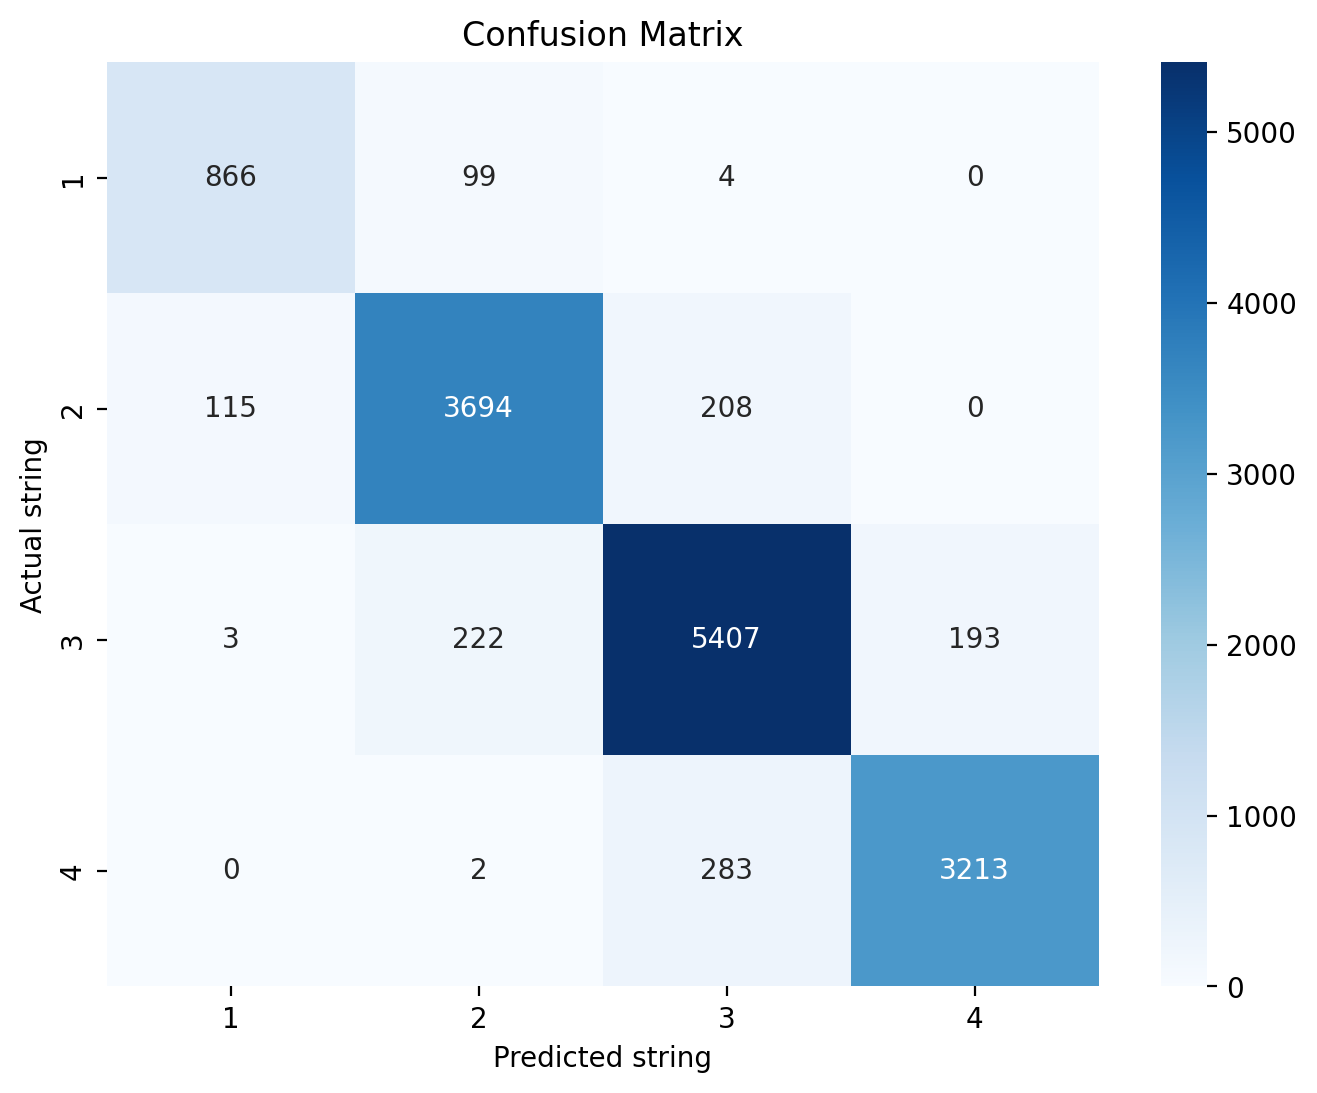

In [28]:
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted string')
plt.ylabel('Actual string')
plt.show()

Through the confusion matrix we can observe how the model shows more weaknesses in predicting the first string: this is most certainly caused by an imbalance of the training data, but we will argue that this is not necessarily a limitation of our model. The first string is the least played in the electric bass, and since our data exclusively comes from that instrument, our model will not be particularly apt at recognizing notes on that string. Coincidentally, we can also infer which strings are the most played on the instrument: unsurprisingly, the second is the preferred one, as it is considered to be the most comfortable string to play on.

Most notably, our model is remarkably good at predicting which string the performer should play, but when it fails to do so, it almost always predict an adjacent string: out of the 13,899 string-fret patterns tested, there have been only 9 “complete” string misclassifications. This is quite an outstanding result if we analyse it contextually: being wrong by a string would shift the note to be played by 5 frets on the instrument, which can put the physical constraints of the performer to test but can be considered a reasonable interval. Larger misclassification in string predictions would make the tablature completely unplayable, and it is an important achievement for our model to be almost completely invulnerable to this case.

# Test on external data

We want to test the effectiveness of our model on a new music score, generated by a music notation software.

We will first check if the notes of the music part are within the range of the bass, where the lowest possible note has pitch = 29. If that's not the case, we will transpose all the notes by an octave through the function "lower octave".

In [29]:
fn = "musicxml/copacabana_raw.musicxml"

xml_data = m21.converter.parse(fn)
xml_list = xml_to_list(xml_data)

df_test_raw = pd.DataFrame(xml_list, columns=['pitch', 'string', 'fret'])
df_test_raw = df_test_raw.applymap(lambda x: int(x) if str(x).strip().isdigit() else x)

if np.min(df_test_raw['pitch']) > 40.0 : df_test_raw = lower_octave(df_test_raw)

df_test_raw.drop(columns="pitch", inplace=True)

df_test_raw

,string,fret
0,3.0,6.0
1,3.0,7.0
2,3.0,8.0
3,3.0,9.0
4,3.0,10.0
...,...,...
468,3.0,10.0
469,3.0,5.0
470,4.0,3.0
471,4.0,3.0


We now generate a DataFrame with the structure that the model requires by adding contextual information of the sorrounding notes.

In [30]:
df_test = generate_contextual_dataframe(df_test_raw)

df_test.drop(columns=['y'], inplace=True)

df_test

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2
0,4,3,4,3,3,6,3,7,3,8
1,4,3,3,6,3,7,3,8,3,9
2,3,6,3,7,3,8,3,9,3,10
3,3,7,3,8,3,9,3,10,3,10
4,3,8,3,9,3,10,3,10,3,10
...,...,...,...,...,...,...,...,...,...,...
468,3,10,3,10,3,10,3,5,4,3
469,3,10,3,10,3,5,4,3,4,3
470,3,10,3,5,4,3,4,3,4,3
471,4,3,4,3,4,3,4,3,4,3


For better results, we now rescale the string-fret combinations so that they are similar to the data used to train the model.

In [31]:
rescale = list()

for i in range(len(df_test)):
    rescale.append(rescale_tab(list(df_test.loc[i])))

df_test = pd.DataFrame(data = rescale, columns=['s-2', 'f-2', 's-1', 'f-1', 's0', 'f0', 's+1', 'f+1', 's+2', 'f+2'])
df_test

,s-2,f-2,s-1,f-1,s0,f0,s+1,f+1,s+2,f+2
0,4,3,4,3,3,6,3,7,3,8
1,4,3,3,6,3,7,3,8,3,9
2,3,6,3,7,3,8,3,9,3,10
3,3,7,3,8,3,9,3,10,3,10
4,3,8,3,9,3,10,3,10,3,10
...,...,...,...,...,...,...,...,...,...,...
468,3,10,3,10,3,10,3,5,4,3
469,3,10,3,10,3,5,4,3,4,3
470,3,10,3,5,4,3,4,3,4,3
471,4,3,4,3,4,3,4,3,4,3


We are now ready to predict the "humanised" string for every note of the music score, and then regenerate the relative fret position.

In [32]:
df_final = df_test[['s0', 'f0']]
df_final['s1'] = [int(model.predict(df_test.iloc[i])) for i in range(len(df_test))]

df_final['f1'] = [regenerate_fret(list(df_final.loc[i])) for i in range(len(df_test))]

df_final

,s0,f0,s1,f1
0,3,6,3,6
1,3,7,3,7
2,3,8,3,8
3,3,9,3,9
4,3,10,2,5
...,...,...,...,...
468,3,10,2,5
469,3,5,3,5
470,4,3,4,3
471,4,3,4,3


Finally, we will substitute the newly-generated string-fret combinations to the old ones in the music score, and we will export the humanised version of the tablature.

In [33]:
import xml.etree.ElementTree as ET

tree = ET.parse('musicxml/copacabana_raw.musicxml')
root = tree.getroot()

i = 0

for elem in root.iter('string'):
    elem.text = str(df_final['s1'][i])
    i+=1

for elem in root.iter('fret'):
    try:
        elem.text = str(df_final['f1'][i])
    except:
        pass #ignoring indexing errors
    i+=1

tree.write("output.musicxml")